# Predicting the EPL relegation zone Using Monte Carlo Simulation.

- Use mathematical model (**Maher model**) to predict which teams will end up relegated
- Model assumes goals scored in each game by the home and away team are **independent variables** and can be modelled by a **Poisson distribution** where the expected number of goals scored by a team depends on a combination of their **attacking strength and the opposing teams defending strength.** 
- Teams are given a small **home advantage.**

**DATA SOURCE** - https://www.football-data.co.uk/englandm.php

Limitations of the Maher model:
- Independence assumptions are not totally correct, events at one of the pitch clearly impacts the other.
- Hot or cold streaks seem to be a result of many factors including team morale and are not just artefacts of a random process.
- Model assumes a teams attacking and defending strength is constant throughout the course of a season.
- Model has no way of forecasting ‘black swan’ events such as an injury to a key player or a team being docked points for match fixing.

In [1]:
import pandas as pd
import numpy as np

from math import factorial
from itertools import product as cart_product

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Calculate optimal alpha, beta & gamma
# ----------------------------------------------------------------------------------------------------------------------------

def optimise_params(df, threshold = 1e-10):
    
    alpha, beta = {}, {}
    gamma = 1.0
    
    for team in df.HomeTeam.unique():
        alpha[team] = 1.0
        beta[team] = 1.0
        
    old = np.zeros(len(alpha)+len(beta)+1)
    while np.abs(np.array(list(alpha.values()) + list(beta.values()) + [gamma]) - old).max() > threshold:
        old = np.array(list(alpha.values()) + list(beta.values()) + [gamma])
        
        denom = 0
        
        for index, row in df.iterrows():
            denom += alpha[row.HomeTeam]*beta[row.AwayTeam]
        gamma = df.FTHG.sum()/denom
        
        for team in df.HomeTeam.unique():
            away_teams = df[df.HomeTeam == team].AwayTeam
            home_teams = df[df.AwayTeam == team].HomeTeam
            
            alpha[team] = (
                    (df[df.HomeTeam == team].FTHG.sum() + df[df.AwayTeam == team].FTAG.sum()) 
                     /(gamma * np.sum([beta[x] for x in away_teams]) + np.sum([beta[x] for x in home_teams]))
                        )
            beta[team] = (
                    (df[df.AwayTeam == team].FTHG.sum() + df[df.HomeTeam == team].FTAG.sum()) 
                     /(gamma * np.sum([alpha[x] for x in home_teams]) + np.sum([alpha[x] for x in away_teams]))
                        )
            
    return alpha, beta, gamma

In [3]:
# Likelihood
# ----------------------------------------------------------------------------------------------------------------------------

def log_likelihood(df, alpha, beta, gamma):
    
    ll = 0
    
    for index, row in df.iterrows():
        home_lambda = alpha[row.HomeTeam] * beta[row.AwayTeam] * gamma
        away_lambda = alpha[row.AwayTeam] * beta[row.HomeTeam]
        
        ll += row.FTHG * np.log(home_lambda) - home_lambda - np.log(factorial(row.FTHG))
        ll += row.FTAG * np.log(away_lambda) - away_lambda - np.log(factorial(row.FTAG))
        
    return ll

In [4]:
# Function to calculate home/away scores probability
# ----------------------------------------------------------------------------------------------------------------------------

def score_probability(home, away, hg, ag, alpha, beta, gamma):
    
    home_lambda = alpha[home] * beta[away] * gamma
    away_lambda = alpha[away] * beta[home]
    
    hg_prob = home_lambda**hg * np.exp(-home_lambda) / factorial(hg)
    ag_prob = away_lambda**ag * np.exp(-away_lambda) / factorial(ag)
    
    return hg_prob*ag_prob

In [5]:
# Predict game outcome using poisson distribution
# ----------------------------------------------------------------------------------------------------------------------------

def predict_game(home, away, alpha, beta, gamma):
    
    return np.random.poisson(alpha[home]*beta[away]*gamma), np.random.poisson(alpha[away]*beta[home])


In [6]:
# Function to Compute points 
# ----------------------------------------------------------------------------------------------------------------------------

def compute_points(df):
    
    points = dict(zip(df.HomeTeam.unique(), [0]*len(df.HomeTeam.unique())))
    
    for index, row in df.iterrows():
        if row.FTHG > row.FTAG:
            points[row.HomeTeam] += 3
        elif row.FTHG == row.FTAG:
            points[row.HomeTeam] += 1
            points[row.AwayTeam] += 1
        else:
            points[row.AwayTeam] += 3
            
    return points

In [7]:
# Load data and fit model
# ----------------------------------------------------------------------------------------------------------------------------

df_raw = pd.read_csv('data\PremierLeague_2019_20.csv')

model = optimise_params(df_raw)
ll = log_likelihood(df_raw, *model)

# Assert that Maximum Likelihood Estimation (MLE) has been found
for team in df_raw.HomeTeam.unique():
    
    for i in [0,1]:
        model[i][team] += 0.01
        assert(log_likelihood(df_raw, *model) < ll)
        model[i][team] -= 0.02
        assert(log_likelihood(df_raw, *model) < ll)
        model[i][team] += 0.01
    
# Assert scores sum to 1
assert(np.isclose(sum([score_probability('Chelsea', 'Man United', hg, ag, *model)
            for hg, ag in cart_product(range(100), range(100))]),1))

In [8]:
df_raw.HomeTeam.unique()

array(['Liverpool', 'West Ham', 'Bournemouth', 'Burnley',
       'Crystal Palace', 'Watford', 'Tottenham', 'Leicester', 'Newcastle',
       'Man United', 'Arsenal', 'Aston Villa', 'Brighton', 'Everton',
       'Norwich', 'Southampton', 'Man City', 'Sheffield United',
       'Chelsea', 'Wolves'], dtype=object)

SUMMING THE PROBABILITIES:
--------------------------------------------
42.96% == Chelsea (Home) win probability
24.63% == Draw probability
32.41% == Man United (Away) win probability
--------------------------------------------


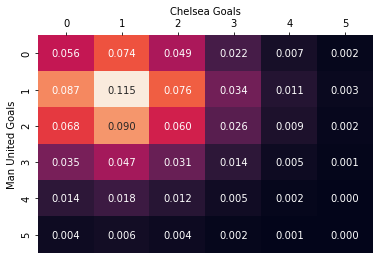

In [9]:
# Predict a match outcome
# ----------------------------------------------------------------------------------------------------------------------------

home = 'Chelsea'
away = 'Man United'
max_goals = 50

score_probs = np.zeros((max_goals, max_goals))

for hg, ag in cart_product(range(max_goals), range(max_goals)):
    
    score_probs[hg, ag] = score_probability(home, away, hg, ag, *model)

# Plot probabilities matrix
plt.figure()

# Compute W,L,D probs
home_win = 0
away_win = 0

for hg, ag in cart_product(range(max_goals), range(max_goals)):
    
    if hg > ag:
        home_win += score_probs[hg, ag]
    elif hg < ag:
        away_win += score_probs[hg, ag]

print('SUMMING THE PROBABILITIES:\n--------------------------------------------')        
print(f'{round(home_win*100,2)}% == {home} (Home) win probability')
print(f'{round(score_probs.diagonal().sum()*100,2)}% == Draw probability')
print(f'{round(away_win*100,2)}% == {away} (Away) win probability\n--------------------------------------------')

# Plot
ax = sns.heatmap(score_probs[:6,:6], annot=True, fmt='.3f', cbar=False)
ax.set_xlabel(home + ' Goals')
ax.set_ylabel(away + ' Goals')
ax.xaxis.set_label_position('top') 
ax.xaxis.tick_top()

In [10]:
# Simulating the results of the remaining fixtures of the season
# ----------------------------------------------------------------------------------------------------------------------------
# -  we obtain the following probabilities for teams winning the league, qualifying for the Champions league, 
#    qualifying for a European competition and getting relegated.

teams = df_raw.HomeTeam.unique()

matches = list(filter(lambda x: x[0] != x[1], cart_product(teams, teams)))
played = list(zip(df_raw.HomeTeam, df_raw.AwayTeam))
to_play = list(filter(lambda x: x not in played, matches))   

# Perform Monte-Carlo simulation

N = 100
points = compute_points(df_raw)
sorted_teams = sorted(teams, key=lambda x: points[x], reverse=True)
counts = pd.DataFrame(0, columns=['Winner', 'CL', 'Europe', 'Relegated'], index=sorted_teams)
mc_margin = []

for i in range(N):
    data = []
    
    for home, away in to_play:
        hg, ag = predict_game(home, away, *model)
        data.append([home, away, hg, ag])
        
    new_results = pd.DataFrame(data, columns=['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG'])
    
    points = compute_points(df_raw.append(new_results, sort=True))
    ranking = sorted(points, key=lambda x: points[x], reverse=True)
    
    counts.Winner[ranking[0]] += 1
    counts.CL[ranking[:4]] += 1
    counts.Europe[ranking[:5]] +=1
    counts.Relegated[ranking[-3:]] += 1
    
print(counts/N)


                  Winner    CL  Europe  Relegated
Liverpool            1.0  1.00    1.00       0.00
Man City             0.0  1.00    1.00       0.00
Leicester            0.0  1.00    1.00       0.00
Chelsea              0.0  0.50    0.75       0.00
Tottenham            0.0  0.28    0.56       0.00
Sheffield United     0.0  0.07    0.23       0.00
Everton              0.0  0.00    0.03       0.00
Wolves               0.0  0.09    0.18       0.00
Man United           0.0  0.05    0.17       0.00
Burnley              0.0  0.00    0.00       0.00
Arsenal              0.0  0.01    0.08       0.00
Newcastle            0.0  0.00    0.00       0.02
Southampton          0.0  0.00    0.00       0.00
Crystal Palace       0.0  0.00    0.00       0.08
Brighton             0.0  0.00    0.00       0.12
Bournemouth          0.0  0.00    0.00       0.51
Aston Villa          0.0  0.00    0.00       0.46
West Ham             0.0  0.00    0.00       0.29
Watford              0.0  0.00    0.00       0.56


In [11]:
new_results[new_results['HomeTeam'] == 'Chelsea']

,HomeTeam,AwayTeam,FTHG,FTAG
109,Chelsea,Watford,4,0
110,Chelsea,Tottenham,0,2
111,Chelsea,Man United,0,4
112,Chelsea,Everton,1,1
113,Chelsea,Norwich,1,3
114,Chelsea,Man City,1,2
115,Chelsea,Wolves,2,2
